<a href="https://colab.research.google.com/github/LuisOlayaNRA/NoteBooks/blob/main/Copia_de_Regresi%C3%B3n_con_RF_y_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 1: Regresión con Random Forest y Gradient Boosting

ELABORADO POR:
  - Luis Eduardo Olaya Díaz
  - Andrés Contreras

En este taller se aplicará ensambes de árboles de decisión tipo random forest y gradient boosting a un conjunto de datos de jugadores del video juego FIFA 19. Los datos utilizados son un subconjunto modificado de [este set de datos](https://www.kaggle.com/karangadiya/fifa19) y se encuentran en el archivo `FIFA 19 players.csv`. La tarea a realizar consiste en predecir el salario (wage) de los jugadores.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from matplotlib import pyplot as plt

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    #BinaryEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [ ]:
#Obtenemos los datos
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE' -O players.csv

--2023-05-23 00:00:03--  https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE
Resolving docs.google.com (docs.google.com)... 108.177.111.100, 108.177.111.138, 108.177.111.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.111.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a35u0m2p126d5286898i8q26istf1j9v/1684800000000/15315348669826032119/*/1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE?e=download&uuid=4052c49e-fd7d-4eb5-90ae-df843f0e1cb9 [following]
--2023-05-23 00:00:04--  https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a35u0m2p126d5286898i8q26istf1j9v/1684800000000/15315348669826032119/*/1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE?e=download&uuid=4052c49e-fd7d-4eb5-90ae-df843f0e1cb9
Resolving doc-0s-6c-docs.googleusercontent.com (doc-0s-6c-docs.googleusercontent.com)... 209.85.234.132, 2607:f

In [ ]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [ ]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

## Preprocesamiento de datos

In [ ]:
# Carguemos los datos:
data = pd.read_csv('players.csv')
data

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,L. Messi,31,94,565000,Left,5.0,4.0,4.0,90.0,90.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,Cristiano Ronaldo,33,94,405000,Right,5.0,4.0,5.0,94.0,94.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,Neymar Jr,26,92,290000,Right,5.0,5.0,5.0,87.0,87.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,K. De Bruyne,27,91,355000,Right,4.0,5.0,4.0,85.0,85.0,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
4,E. Hazard,27,91,340000,Right,4.0,4.0,4.0,86.0,86.0,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,1000,Right,1.0,2.0,2.0,44.0,44.0,...,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0
15922,N. Christoffersson,19,47,1000,Right,1.0,2.0,2.0,47.0,47.0,...,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0
15923,B. Worman,16,47,1000,Right,1.0,3.0,2.0,47.0,47.0,...,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0
15924,D. Walker-Rice,17,47,1000,Right,1.0,3.0,2.0,49.0,49.0,...,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0


In [ ]:
# Veamos la descripción del dataset:
data.describe(include='all')

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,15926,15926.000000,15926.000000,15926.000000,15926,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,...,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.00000,15926.000000,15926.000000,15926.000000
unique,15114,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,J. Rodríguez,NaN,NaN,NaN,Right,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,9,NaN,NaN,NaN,11969,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,24.991209,66.446189,10254.866256,NaN,1.116037,3.004081,2.533342,59.842647,59.842647,...,51.446126,59.575411,50.401168,54.844405,55.494726,52.118234,60.34654,51.273703,51.883021,49.593118
std,NaN,4.552866,6.809244,22692.769542,NaN,0.397762,0.636845,0.618186,9.141407,9.141407,...,15.718376,14.432944,18.797738,14.665434,12.897478,12.501841,10.14202,17.198926,19.161875,19.162508
min,NaN,16.000000,46.000000,1000.000000,NaN,1.000000,1.000000,2.000000,33.000000,33.000000,...,11.000000,13.000000,10.000000,11.000000,12.000000,12.000000,29.00000,10.000000,10.000000,10.000000
25%,NaN,21.000000,62.000000,1000.000000,NaN,1.000000,3.000000,2.000000,54.000000,54.000000,...,40.000000,50.000000,34.000000,46.000000,47.000000,42.000000,53.00000,37.000000,35.000000,32.000000
50%,NaN,25.000000,66.000000,3000.000000,NaN,1.000000,3.000000,2.000000,60.000000,60.000000,...,54.000000,61.000000,56.000000,57.000000,57.000000,52.000000,61.00000,56.000000,59.000000,56.000000
75%,NaN,28.000000,71.000000,10000.000000,NaN,1.000000,3.000000,3.000000,66.000000,66.000000,...,64.000000,70.000000,65.000000,65.000000,65.000000,61.000000,68.00000,65.000000,67.000000,65.000000


In [ ]:
data.isnull().sum()

Name              0
Age               0
Overall           0
Wage              0
Preferred Foot    0
                 ..
Penalties         0
Composure         0
Marking           0
StandingTackle    0
SlidingTackle     0
Length: 63, dtype: int64

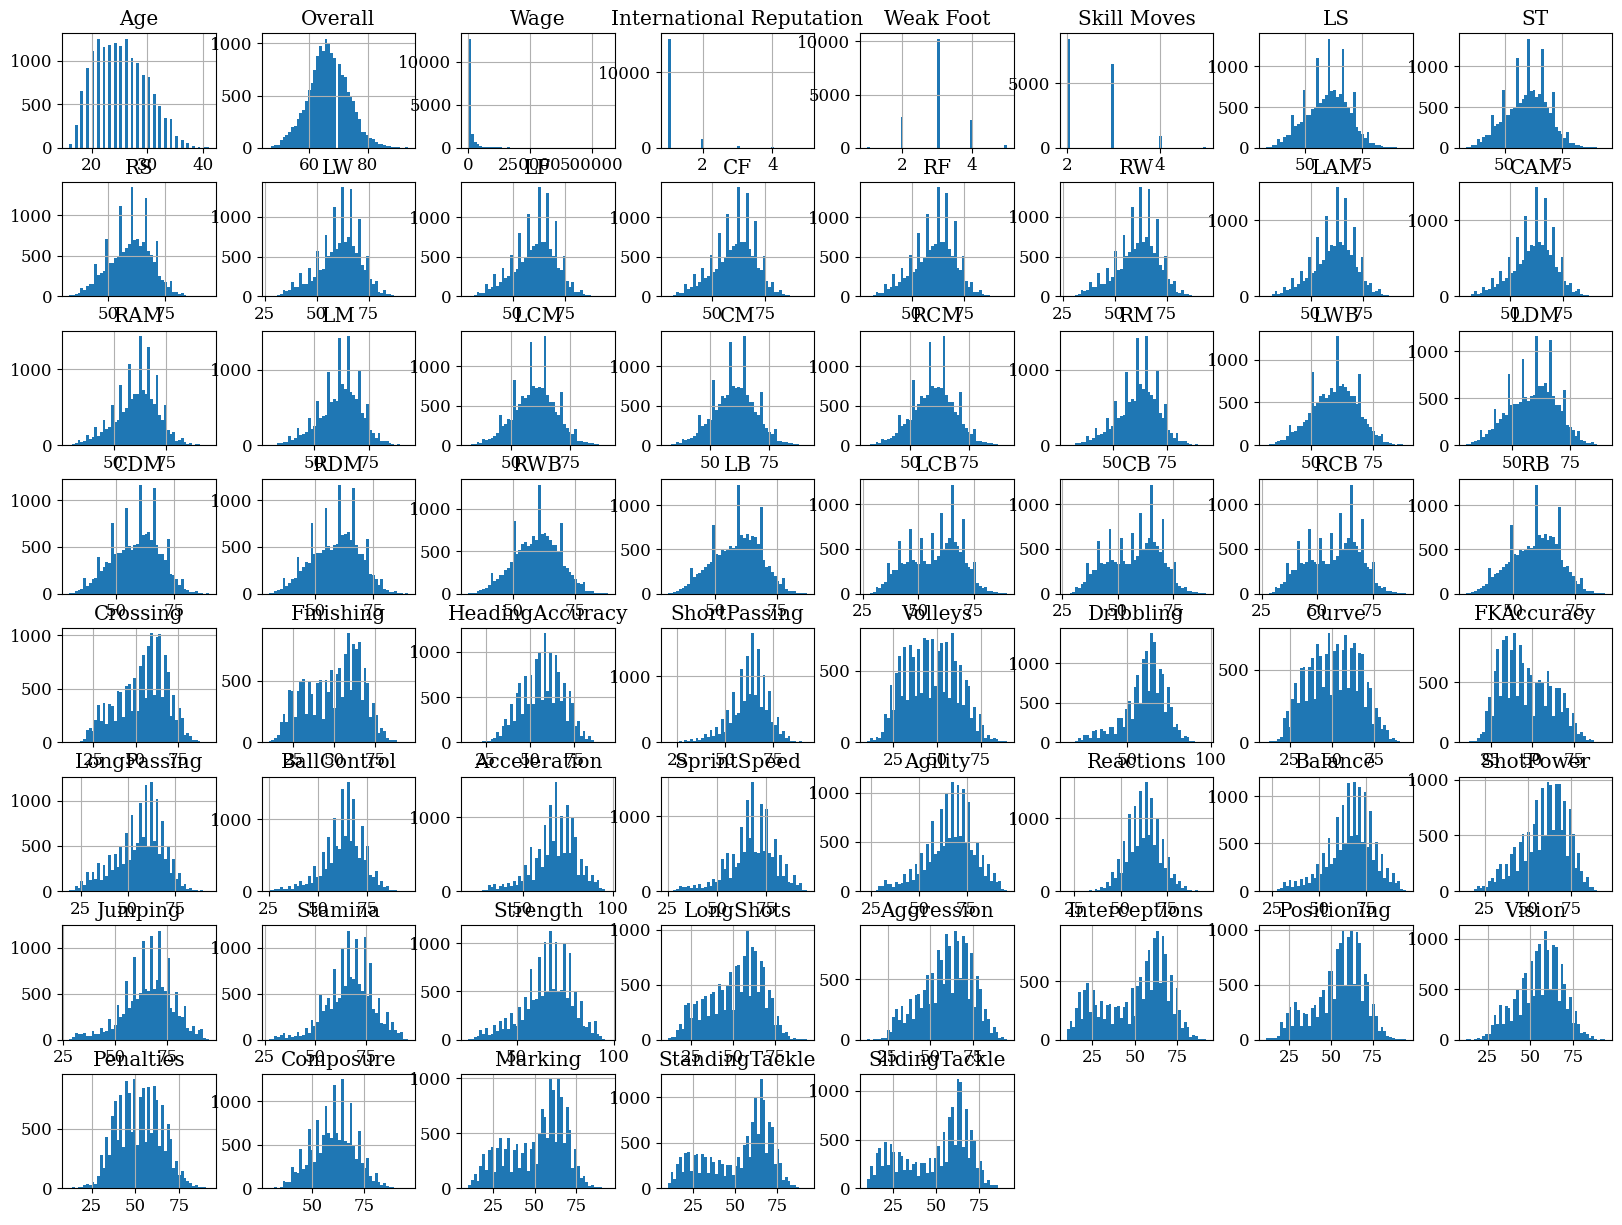

In [ ]:
#Veamos la distribución de las columnas
data.hist(bins=50, figsize=(20, 15));

In [ ]:
#@title Texto de título predeterminado
# Obtengamos la distribución de valores de la variable `Preferred Foot`:
# tip: pandas function value_counts()
value_counts = data['Preferred Foot'].value_counts()
distribution = value_counts / value_counts.sum()
print(distribution)


Right    0.751538
Left     0.248462
Name: Preferred Foot, dtype: float64


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class MergeElectricToOther(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy


In [ ]:
# Dado que esta columna es categorica, debemos incluir en el Pipeline su transformación. Utilizaremos 
# codificación binaria
#tip: scikit-learn BinaryEncoder -> Igual funcionamiento a OrdinalEncoder
# Crear el pipeline
# Hay que instalar el  !pip install category_encoders

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder

# Crear el pipeline

pipeline = Pipeline([
    ('merge_electric_to_other', MergeElectricToOther(column_name='fuelType'))
])

# Fit and transform the data
df_transformed = pipeline.fit_transform(data)
print(df_transformed)

                     Name  Age  Overall    Wage Preferred Foot  \
0                L. Messi   31       94  565000           Left   
1       Cristiano Ronaldo   33       94  405000          Right   
2               Neymar Jr   26       92  290000          Right   
3            K. De Bruyne   27       91  355000          Right   
4               E. Hazard   27       91  340000          Right   
...                   ...  ...      ...     ...            ...   
15921        J. Lundstram   19       47    1000          Right   
15922  N. Christoffersson   19       47    1000          Right   
15923           B. Worman   16       47    1000          Right   
15924      D. Walker-Rice   17       47    1000          Right   
15925           G. Nugent   16       46    1000          Right   

       International Reputation  Weak Foot  Skill Moves    LS    ST  ...  \
0                           5.0        4.0          4.0  90.0  90.0  ...   
1                           5.0        4.0          5.0

In [ ]:
df_transformed.value_counts()

Name            Age  Overall  Wage   Preferred Foot  International Reputation  Weak Foot  Skill Moves  LS    ST    RS    LW    LF    CF    RF    RW    LAM   CAM   RAM   LM    LCM   CM    RCM   RM    LWB   LDM   CDM   RDM   RWB   LB    LCB   CB    RCB   RB    Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  Agility  Reactions  Balance  ShotPower  Jumping  Stamina  Strength  LongShots  Aggression  Interceptions  Positioning  Vision  Penalties  Composure  Marking  StandingTackle  SlidingTackle
A. Abang        21   62       1000   Right           1.0                       2.0        2.0          63.0  63.0  63.0  57.0  59.0  59.0  59.0  57.0  56.0  56.0  56.0  55.0  49.0  49.0  49.0  55.0  44.0  42.0  42.0  42.0  44.0  43.0  43.0  43.0  43.0  43.0  30.0      61.0       67.0             52.0          58.0     56.0       30.0   28.0        28.0         59.0         68.0          68.0         66.0  

## Regresión

**Nota:** Dejaremos la coulmna `Name` en el datafrme para poder identificar a los jugadores, pero **la debemos excluir** al definir las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test`.

In [ ]:
# Separemos los datos en conjuntos de entrenamiento (80 %) y prueba (20 %):
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns='Wage'),
    data.Wage, test_size=0.2,
    random_state=random_state
)


In [ ]:
#Definimos las transformaciones
cat_cols = X_train.select_dtypes(include=object).columns
num_cols = X_train.select_dtypes(include=np.number).columns

categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)
numerical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers = [
       ('cat',categorical_transformer,cat_cols)   
      ])

#Definimos nuestro Pipeline de pre-procesamiento
preprocessor = ColumnTransformer(
    transformers = [
       ('cat',categorical_transformer,cat_cols)   
      ])

#Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

pipeline_rf = Pipeline(steps = [
    ('merge_electric_to_other', MergeElectricToOther(column_name='fuelType')),
    ('preprocessor', preprocessor),
    ('regressor', rf_base),
                            ])

pipeline_gb = Pipeline(steps = [
    ('merge_electric_to_other', MergeElectricToOther(column_name='fuelType')),
    ('preprocessor', preprocessor),
    ('regressor', gb_base),
    ])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)

In [ ]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

CPU times: user 56.3 s, sys: 109 ms, total: 56.4 s
Wall time: 56.5 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('merge_electric_to_other',
                                        MergeElectricToOther(column_name='fuelType')),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         Index(['Name', 'Preferred Foot'], dtype='object'))])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [6, 7, 8, 9],
                         'regressor__min_samples_leaf': [10, 300, 2000],
                         'regressor__n_estimators': [50, 100]})

In [ ]:
print(rf.best_params_)
print(gb.best_params_)

{'regressor__max_depth': 6, 'regressor__min_samples_leaf': 2000, 'regressor__n_estimators': 50}
{'regressor__max_depth': 6, 'regressor__min_samples_leaf': 2000, 'regressor__n_estimators': 100}


In [ ]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_train, y_train)}')
    print(f'MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
    print('\n')

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
    print('\n')

Train set
Model: Random Forest
R^2: 0.0007967014887709789
MAE: 10771.57765922813


Model: Gradient Boosting
R^2: 0.005062011020433244
MAE: 10732.851715466513


Test set
Model: Random Forest
R^2: -0.00021573096198701514
MAE: 11486.484595439659


Model: Gradient Boosting
R^2: -0.00038144229579573086
MAE: 11277.169768152233




In [ ]:
# Veamos los datos junto con las predicciones:
pd.concat([
    data.drop(columns='Wage').reset_index(drop=True),
    data['Wage'].reset_index(drop=True),
    pd.DataFrame({'rf_predicted_wage': rf.predict(data.drop(columns=['Wage']))}),
    pd.DataFrame({'gb_predicted_wage': gb.predict(data.drop(columns=['Wage']))})
], axis=1)

,Name,Age,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Wage,rf_predicted_wage,gb_predicted_wage
0,L. Messi,31,94,Left,5.0,4.0,4.0,90.0,90.0,90.0,...,94.0,94.0,75.0,96.0,33.0,28.0,26.0,565000,10450.051450,10095.294934
1,Cristiano Ronaldo,33,94,Right,5.0,4.0,5.0,94.0,94.0,94.0,...,95.0,82.0,85.0,95.0,28.0,31.0,23.0,405000,10425.634776,10588.669055
2,Neymar Jr,26,92,Right,5.0,5.0,5.0,87.0,87.0,87.0,...,89.0,87.0,81.0,94.0,27.0,24.0,33.0,290000,10787.018931,10859.710066
3,K. De Bruyne,27,91,Right,4.0,5.0,4.0,85.0,85.0,85.0,...,87.0,94.0,79.0,88.0,68.0,58.0,51.0,355000,10425.634776,10005.580583
4,E. Hazard,27,91,Right,4.0,4.0,4.0,86.0,86.0,86.0,...,87.0,89.0,86.0,91.0,34.0,27.0,22.0,340000,10216.820924,12247.089155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,Right,1.0,2.0,2.0,44.0,44.0,44.0,...,39.0,52.0,43.0,45.0,40.0,48.0,47.0,1000,9343.941538,8751.774109
15922,N. Christoffersson,19,47,Right,1.0,2.0,2.0,47.0,47.0,47.0,...,46.0,33.0,43.0,42.0,22.0,15.0,19.0,1000,10806.883654,11027.019533
15923,B. Worman,16,47,Right,1.0,3.0,2.0,47.0,47.0,47.0,...,48.0,43.0,55.0,41.0,32.0,13.0,11.0,1000,10425.634776,10005.580583
15924,D. Walker-Rice,17,47,Right,1.0,3.0,2.0,49.0,49.0,49.0,...,44.0,47.0,50.0,46.0,20.0,25.0,27.0,1000,10425.634776,10242.125440


Explicabilidad

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.0 MB/s eta 0:00:00


In [ ]:
import shap
from IPython.display import HTML

In [ ]:
# Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('merge_electric_to_other',
                 MergeElectricToOther(column_name='fuelType')),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['Name', 'Preferred Foot'], dtype='object'))])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=6, min_samples_leaf=2000,
                                           random_state=42))])

In [ ]:
# Aplicamos el preproceso a los datos
X_train_preprocessed = pipeline_gb.named_steps['merge_electric_to_other'].transform(X_train)
X_test_preprocessed = pipeline_gb.named_steps['merge_electric_to_other'].transform(X_test)


In [ ]:
# Entrenemos nuestro modelo de explicabilidad
gb_explainer = shap.TreeExplainer(pipeline_gb.named_steps["regressor"])
train_gb_shap_values = gb_explainer.shap_values(X_train_preprocessed)

ValueError: ignored

In [ ]:
# Summary plot
test_gb_shap_values = gb_explainer.shap_values(X_test_preprocessed)
test_gb_shap_values[1].shape
shap.summary_plot(test_gb_shap_values, X_test, plot_type="bar")

ValueError: ignored

In [ ]:
# Grafiquemos los valores SHAP para un ejemplo del conjunto de test
shap.initjs()

# Individual SHAP value plot for a specific instance (e.g., the first instance in the test set)
instance_index = 0
force_plot_html = shap.force_plot(gb_explainer.expected_value, test_gb_shap_values[instance_index], X_test.iloc[instance_index],show=False)
HTML(force_plot_html.html())

In [ ]:
# Grafiquemos la dependencia de los valores SHAP con la variable "Age"
shap.dependence_plot('Age', test_gb_shap_values, X_test)